In [2]:
# [Markdown Cell]: # 1. การนำเข้าข้อมูลและไลบรารีที่จำเป็น
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# นำเข้าข้อมูล
df = pd.read_csv('data/train.csv')
print(f"จำนวนข้อมูลทั้งหมด: {df.shape[0]} แถว, {df.shape[1]} คอลัมน์")

จำนวนข้อมูลทั้งหมด: 1460 แถว, 81 คอลัมน์


In [3]:
# [Markdown Cell]: # 2. การจัดเตรียมและทำความสะอาดข้อมูล (Data Cleansing)
# ปัญหา: ค่า 'NA' ในหลายคอลัมน์ไม่ได้แปลว่าข้อมูลหาย แต่แปลว่า 'ไม่มี' (เช่น ไม่มีสระว่ายน้ำ)
cols_fill_none = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                  'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

for col in cols_fill_none:
    df[col] = df[col].fillna('None')

# เติมค่าว่างที่เป็นตัวเลขด้วยค่ามัธยฐาน (Median)
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

print("จำนวนข้อมูลที่สูญหาย (Missing Values) หลังทำความสะอาด:")
print(df[['Alley', 'LotFrontage', 'GarageType']].isnull().sum())

จำนวนข้อมูลที่สูญหาย (Missing Values) หลังทำความสะอาด:
Alley          0
LotFrontage    0
GarageType     0
dtype: int64


In [4]:
# [Markdown Cell]: # 3. Feature Engineering (สร้างตัวแปรใหม่เพื่อตอบคำถาม)
# สร้างคอลัมน์ ราคาต่อตารางฟุต (PricePerSqFt) เพื่อตอบคำถามที่ 2
df['PricePerSqFt'] = df['SalePrice'] / df['GrLivArea']

# สร้างตัวแปรระบุว่าบ้านขายได้สูงกว่าราคากลางหรือไม่ (เพื่อตอบคำถามที่ 3)
median_price = df['SalePrice'].median()
df['AboveMedian'] = df['SalePrice'] > median_price

print(f"ราคากลางของตลาดคือ: ${median_price:,.2f}")

ราคากลางของตลาดคือ: $163,000.00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


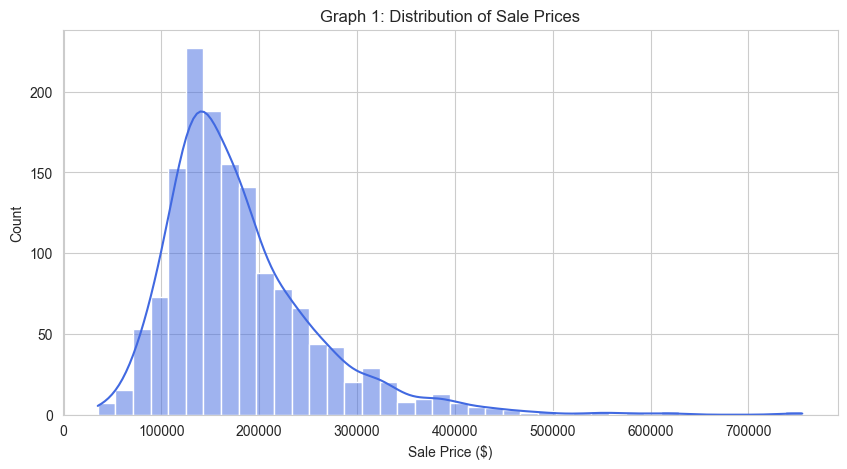

/var/folders/9n/sxwww5_j4bl8bp48bvw_csh40000gn/T/ipykernel_73287/1268254848.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='OverallQual', y='SalePrice', data=df, palette='viridis')


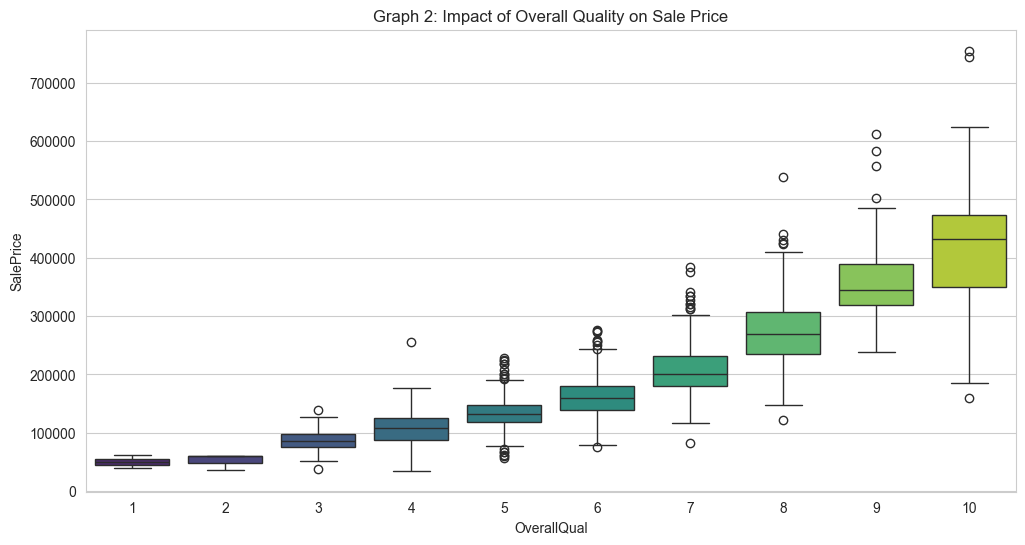

/var/folders/9n/sxwww5_j4bl8bp48bvw_csh40000gn/T/ipykernel_73287/1268254848.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=neighborhood_price.index, y=neighborhood_price.values, palette='magma')


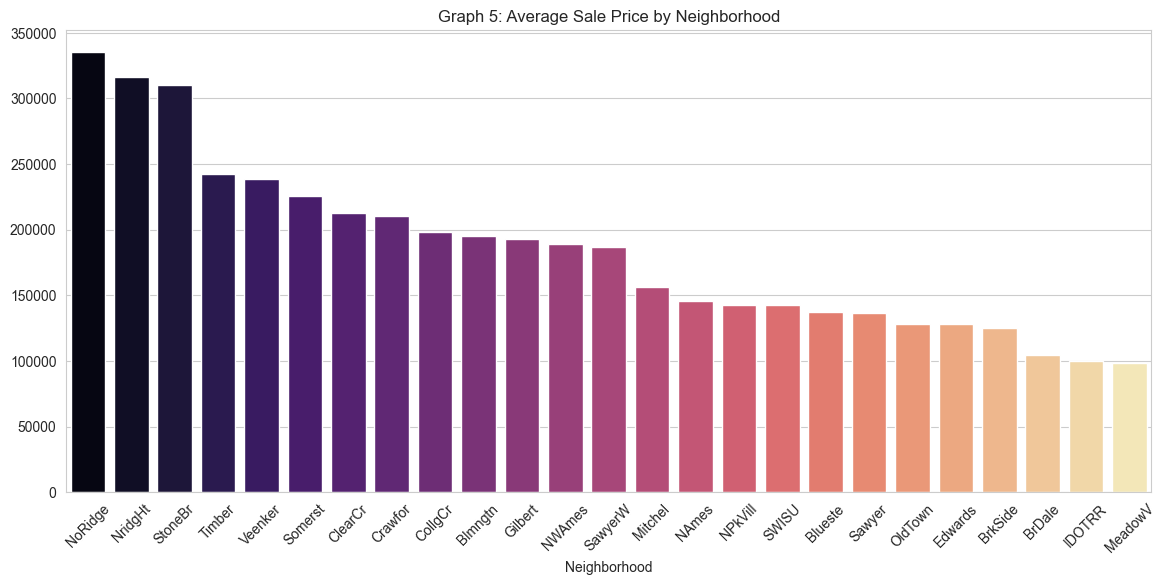

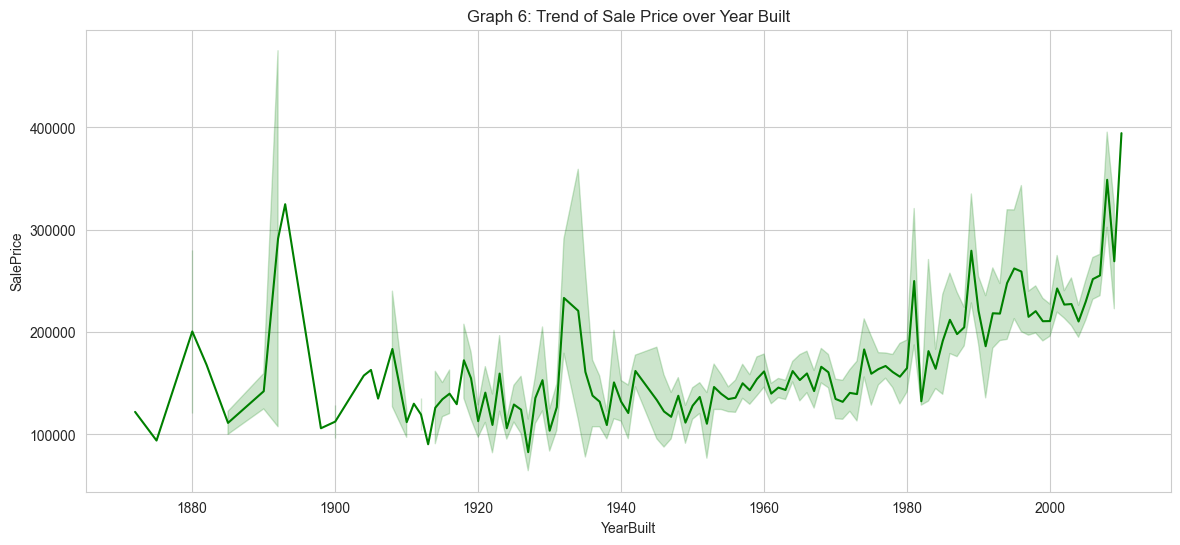

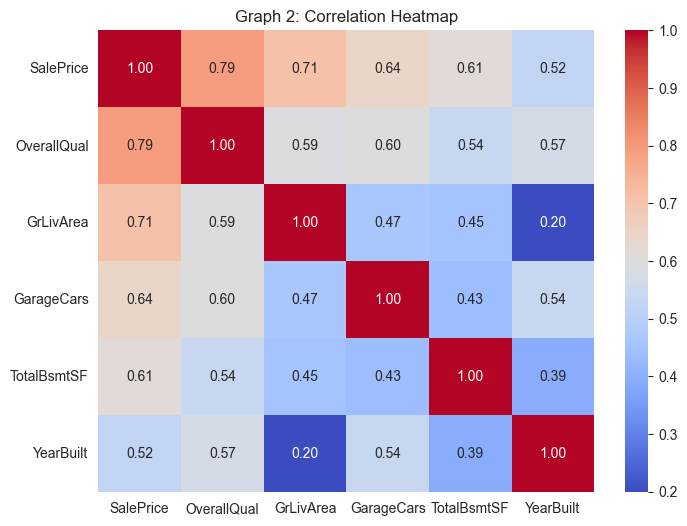

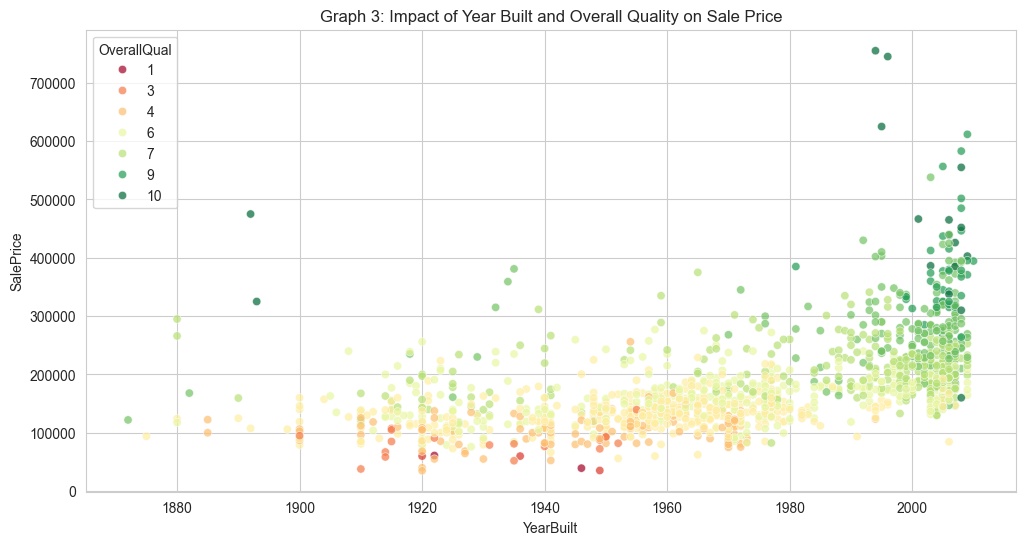

/var/folders/9n/sxwww5_j4bl8bp48bvw_csh40000gn/T/ipykernel_73287/1268254848.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_hood.index, y=val_hood.values, palette='viridis')


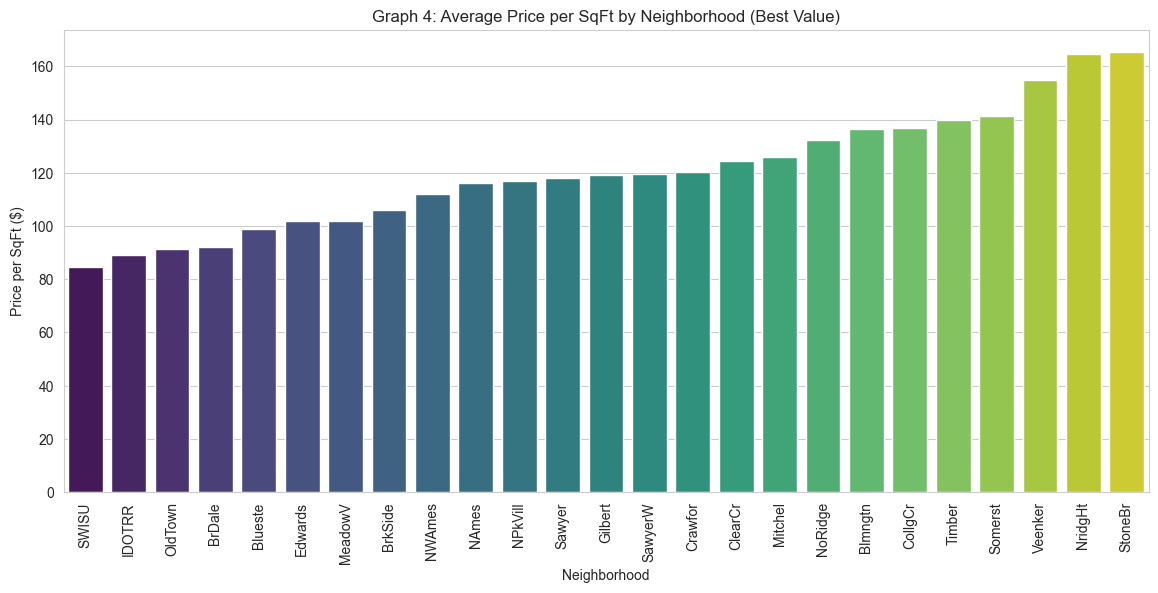

/var/folders/9n/sxwww5_j4bl8bp48bvw_csh40000gn/T/ipykernel_73287/1268254848.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CentralAir', y='SalePrice', data=df, palette='Set2')
/var/folders/9n/sxwww5_j4bl8bp48bvw_csh40000gn/T/ipykernel_73287/1268254848.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Fireplaces', y='SalePrice', data=df, palette='Set2')
/var/folders/9n/sxwww5_j4bl8bp48bvw_csh40000gn/T/ipykernel_73287/1268254848.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GarageCars', y='SalePrice', data=df, palette=

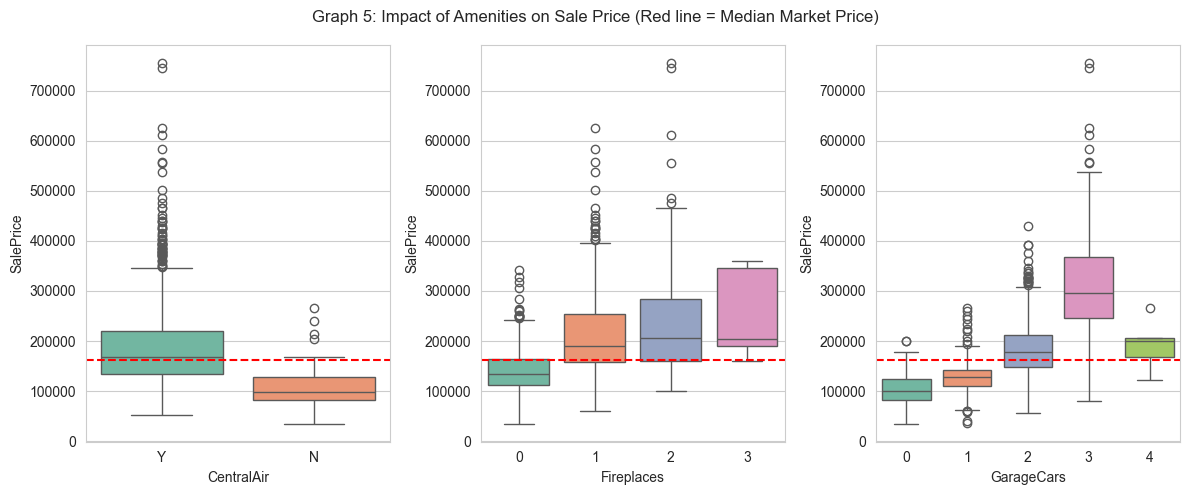

In [5]:
# [Markdown Cell]: # 4. การสำรวจและวิเคราะห์ข้อมูล (EDA - 6 กราฟ)
sns.set_style("whitegrid")

# กราฟที่ 1: การกระจายตัวของราคา (Distribution)
plt.figure(figsize=(10,5))
sns.histplot(df['SalePrice'], kde=True, bins=40, color='royalblue')
plt.title('Graph 1: Distribution of Sale Prices')
plt.xlabel('Sale Price ($)')
plt.show()

# Graph 2: Overall Quality vs Sale Price
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=df, palette='viridis')
plt.title('Graph 2: Impact of Overall Quality on Sale Price')
plt.show()

# Graph 3: Average Price by Neighborhood
plt.figure(figsize=(14, 6))
neighborhood_price = df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False)
sns.barplot(x=neighborhood_price.index, y=neighborhood_price.values, palette='magma')
plt.xticks(rotation=45)
plt.title('Graph 5: Average Sale Price by Neighborhood')
plt.show()

# Graph 4: Year Built vs Sale Price
plt.figure(figsize=(14, 6))
sns.lineplot(x='YearBuilt', y='SalePrice', data=df, color='green')
plt.title('Graph 6: Trend of Sale Price over Year Built')
plt.show()

# กราฟที่ 5: Heatmap หาปัจจัยที่มีผลสุด
plt.figure(figsize=(8,6))
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt']
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Graph 2: Correlation Heatmap')
plt.show()

# กราฟที่ 3: ตอบคำถาม 1 (Quality vs YearBuilt vs Price)
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x='YearBuilt', y='SalePrice', hue='OverallQual', palette='RdYlGn', alpha=0.7)
plt.title('Graph 3: Impact of Year Built and Overall Quality on Sale Price')
plt.show()

# กราฟที่ 6: ตอบคำถาม 2 (Best Value Neighborhood)
plt.figure(figsize=(14,6))
val_hood = df.groupby('Neighborhood')['PricePerSqFt'].mean().sort_values()
sns.barplot(x=val_hood.index, y=val_hood.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Graph 4: Average Price per SqFt by Neighborhood (Best Value)')
plt.ylabel('Price per SqFt ($)')
plt.show()

# กราฟที่ 7: ตอบคำถาม 3 (Amenities Impact)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
sns.boxplot(x='CentralAir', y='SalePrice', data=df, palette='Set2')
plt.axhline(median_price, color='red', linestyle='--')
plt.subplot(1,3,2)
sns.boxplot(x='Fireplaces', y='SalePrice', data=df, palette='Set2')
plt.axhline(median_price, color='red', linestyle='--')
plt.subplot(1,3,3)
sns.boxplot(x='GarageCars', y='SalePrice', data=df, palette='Set2')
plt.axhline(median_price, color='red', linestyle='--')
plt.suptitle('Graph 5: Impact of Amenities on Sale Price (Red line = Median Market Price)')
plt.tight_layout()
plt.show()

----------------------------------------
📊 ประสิทธิภาพของโมเดล (Model Performance)
----------------------------------------
R-Squared (ความแม่นยำ): 0.8908 (โมเดลอธิบายความผันผวนของราคาได้ 89.08%)
RMSE (ความคลาดเคลื่อนกำลังสองเฉลี่ย): $28,944.84
MAE (ความคลาดเคลื่อนสัมบูรณ์เฉลี่ย): $19,210.21
----------------------------------------


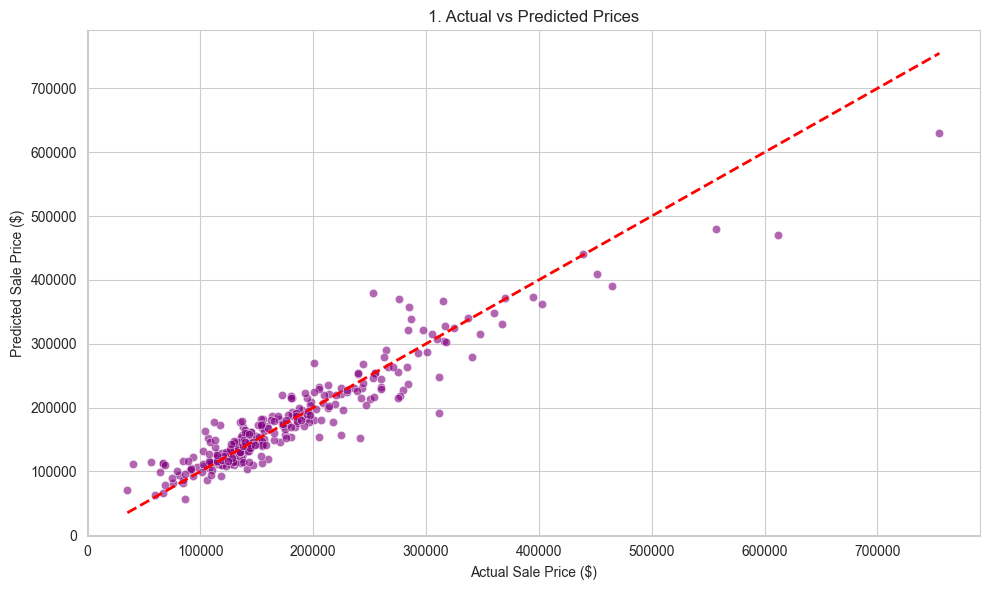

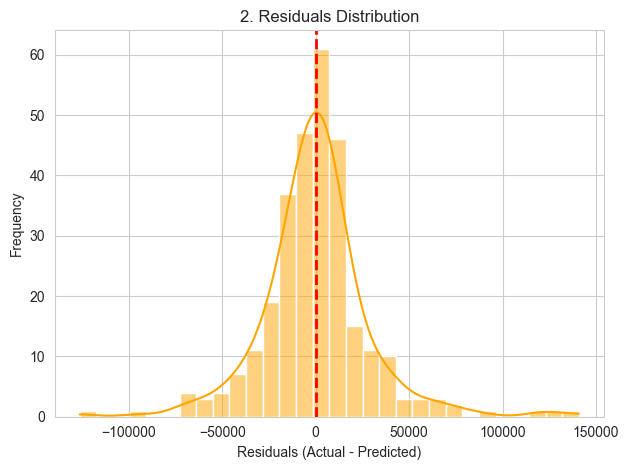

/var/folders/9n/sxwww5_j4bl8bp48bvw_csh40000gn/T/ipykernel_73287/4145744098.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')


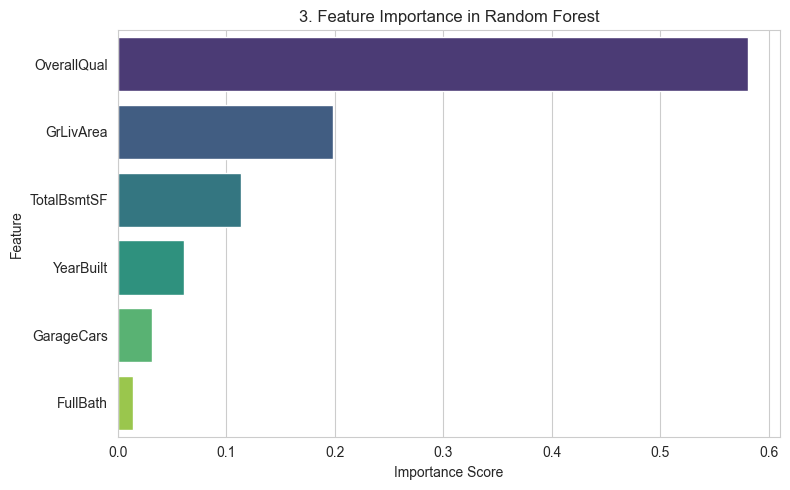

In [6]:
# [Markdown Cell]: 
# # 5. การสร้างแบบจำลอง Machine Learning และประเมินผล (Model Prediction & Analysis)
# ในส่วนนี้เราจะใช้ Random Forest Regressor เพื่อทำนายราคาบ้าน และวิเคราะห์ว่าโมเดลใช้ปัจจัยใดในการตัดสินใจมากที่สุด

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 5.1 เลือก Features และเป้าหมาย (Target)
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 'FullBath']
X = df[features].fillna(0) # จัดการค่าว่างเบื้องต้นด้วย 0
y = df['SalePrice']

# 5.2 แบ่งข้อมูลเป็นชุดฝึกสอน (Train) และชุดทดสอบ (Test) 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5.3 สร้างและฝึกสอนโมเดล
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5.4 ประเมินผล (Evaluate)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("-" * 40)
print("📊 ประสิทธิภาพของโมเดล (Model Performance)")
print("-" * 40)
print(f"R-Squared (ความแม่นยำ): {r2:.4f} (โมเดลอธิบายความผันผวนของราคาได้ {r2*100:.2f}%)")
print(f"RMSE (ความคลาดเคลื่อนกำลังสองเฉลี่ย): ${rmse:,.2f}")
print(f"MAE (ความคลาดเคลื่อนสัมบูรณ์เฉลี่ย): ${mae:,.2f}")
print("-" * 40)

# ==========================================
# 5.5 Visualizing Model Analysis (สร้างกราฟวิเคราะห์โมเดล)
# ==========================================
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# กราฟที่ 1: Actual vs Predicted (ราคาจริง เทียบกับ ราคาที่ทำนายได้)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sale Price ($)')
plt.ylabel('Predicted Sale Price ($)')
plt.title('1. Actual vs Predicted Prices')
plt.tight_layout()
plt.show()

# กราฟที่ 2: Residual Distribution (การกระจายตัวของค่าความคลาดเคลื่อน)
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, color='orange', bins=30)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('2. Residuals Distribution')
plt.tight_layout()
plt.show()

# กราฟที่ 3: Feature Importance (ความสำคัญของตัวแปร)
importances = model.feature_importances_
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title('3. Feature Importance in Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


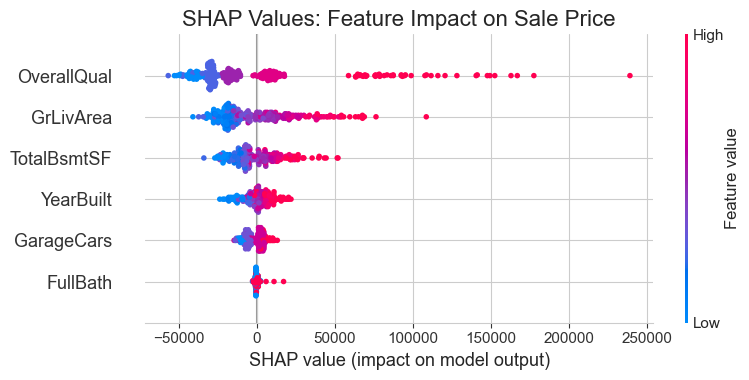

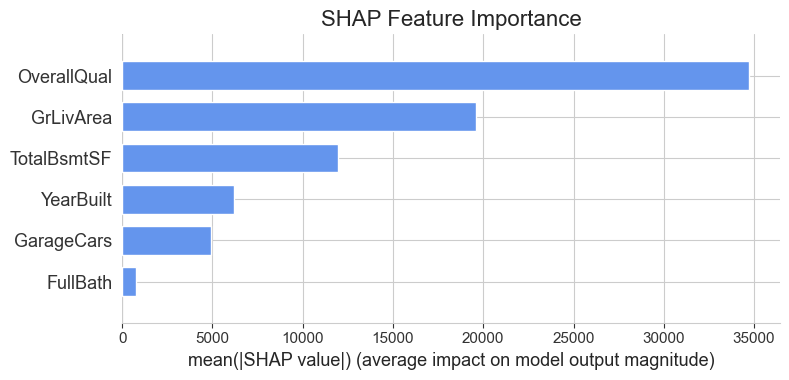

In [7]:
# ==========================================
# 5.6 การวิเคราะห์เชิงลึกด้วย SHAP Values
# ==========================================
import shap

# โหลด JavaScript สำหรับการแสดงผล SHAP ใน Notebook
shap.initjs()

# สร้าง Explainer จากโมเดล Random Forest ที่เราเทรนไว้
explainer = shap.TreeExplainer(model)

# คำนวณค่า SHAP values จากชุดข้อมูลทดสอบ (X_test)
shap_values = explainer.shap_values(X_test)

# ----------------------------------------------------
# กราฟ 1: SHAP Summary Plot (Beeswarm Plot)
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
plt.title('SHAP Values: Feature Impact on Sale Price', fontsize=16)
# show=False เพื่อให้เราสามารถใช้ plt.show() หรือปรับแต่งกราฟต่อได้
shap.summary_plot(shap_values, X_test, show=False) 
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# กราฟ 2: SHAP Feature Importance (Bar Plot)
# (ให้ผลคล้าย Feature Importance เดิม แต่อิงจากหลักการ Game Theory)
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
plt.title('SHAP Feature Importance', fontsize=16)
shap.summary_plot(shap_values, X_test, plot_type="bar", color="cornflowerblue", show=False)
plt.tight_layout()
plt.show()